In [1]:
try:
    from calculations import *
    import sys
    import time
    import numpy as np
    import matplotlib.pyplot as plt
    from beyond.dates import Date, timedelta
    from beyond.io.tle import Tle
    from beyond.frames import create_station
    from beyond.config import config
except:
    import pip
    pip.main(['install','beyond'])

## Configuration

In [2]:
tle_file="iss.tle" #Two line element file location
gps = np.array([51.03594,5.72767,34]) #GPS + height in meters
timestep = 30 #How many seconds per calculation step?
iterations = 3 #How many passes ?
minimum_angle = None #FIX
terminal_output = True
file_output = False #FIX
polydegree = 1 #FIX

In [3]:
azimuths, elevations = [], [] #Define arrays for storing angles

In [4]:
station = create_station('Radio Telescope', gps)

In [5]:
#Parse the tle file and convert to orbit object
tle = Tle(parse_tle(tle_file)).orbit()

## View orbital parameters

In [6]:
print(repr(tle))


Orbit =
  date = 2021-11-29T11:53:28.588128 UTC
  form = tle
  frame = TEME
  propag = Sgp4
  coord =
    i = 0.9013578388999515
    Ω = 4.2820099854646605
    e = 0.0004305
    ω = 4.524794011063332
    M = 4.778152986599836
    n = 0.0011262493475096662



## Calculation

In [7]:
print("          Time     Elev    Azimuth  Distance Radial Velocity")
print("=========================================================")
azimuths, elevations = [[]] * iterations, [[]] * iterations
iteration = 0
maximum_angle = 0
for orbit in station.visibility(tle, start=Date.now(), stop=timedelta(hours=100), step=timedelta(seconds=timestep), events=True):
    #Angle conversion from radians to degrees
    elevation = np.degrees(orbit.phi)
    azimuth = np.degrees(-orbit.theta) % 360
    
    azimuths[iteration].append(azimuth)
    elevations[iteration].append(90 - elevation)

    if elevation > maximum_angle: maximum_angle = elevation
    
    r = orbit.r / 1000.
    try:
        event = event_parser(orbit.event)   
    except:
        event = ""
            


    if terminal_output: print("{event:7} {orb.date:%H:%M:%S} {elev:7.1f} {azim:7.1f} {r:10.1f} {orb.r_dot:10.1f}".format(orb=orbit, r=r, azim=azimuth, elev=elevation, event=event if orbit.event is not None else ""))
    
    if orbit.event and orbit.event.info.startswith("LOS"):
        
        #if file_output:
            #filename = Date.now().str + ".csv"
            #file = open("test.csv", 'w')
            #file.print("hello")
            #file.close()
        
        print() #Stop after one pass
        if minimum_angle and maximum_angle < minimum_angle:
            azimuths.pop(iteration)
            elevations.pop(iteration)
        else:
            iteration += 1

        maximum_angle = 0
        if iteration == iterations: break
    


          Time     Elev    Azimuth  Distance Radial Velocity
VIS     12:07:10     0.0   141.6     2382.4    -1886.9
        12:07:15     0.1   140.7     2372.8    -1786.9
        12:07:45     0.5   135.5     2328.0    -1190.7
        12:08:15     0.7   130.1     2301.7     -564.9
MAX     12:08:41     0.8   125.3     2294.2      -13.1
        12:08:45     0.8   124.6     2294.3       75.9
        12:09:15     0.7   119.1     2306.2      715.1
        12:09:45     0.4   113.7     2337.0     1336.5
LOS     12:10:12    -0.0   109.0     2380.0     1865.2

VIS     13:39:26     0.0   206.2     2382.9    -6210.0
        13:39:45     1.1   204.6     2263.3    -6124.7
        13:40:15     2.9   201.8     2082.0    -5956.8
        13:40:45     4.8   198.5     1906.5    -5732.2
        13:41:15     6.9   194.4     1738.8    -5430.6
        13:41:45     9.1   189.5     1581.7    -5024.4
        13:42:15    11.3   183.4     1438.7    -4477.7
        13:42:45    13.6   176.0     1314.8    -3750.0
   

Printing pass 0 in color navy
Printing pass 1 in color cyan
Printing pass 2 in color red


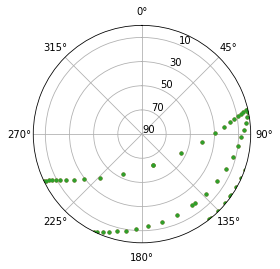

In [8]:
plot_polar(azimuths,elevations,polydegree)